# Overfitting Crab Age :older_adult: :crab:

*In which we practice one thing so much that we get worse at everything else.*


### Define Constants


In [1]:
CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../1-models/models.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

MODEL_CHECKPOINT_FILE = '../cache/overfit_model.weights.h5'


### Importing Libraries

PyTorch supports windows-native CUDA, but TensorFlow on CPU was faster for this task.


In [2]:
from notebooks.time_for_crab.mlutils import display_df, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Load Data from Cache

In the [previous section](../0-eda/eda.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [3]:
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

### Overfitting Crab Age

![Large mud crab measure](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg/1920px-CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg)


### Overfitting Goals and Methods 

The goal here is to show how complex of a model it will take to overfit the data.

We will use the following methods to overfit the data:

1. **Linear Regression**: Gradually increase the complexity of a linear regression model.
2. **Model Stacking**: Stack models to overfit the model.

> There are two steps in your single-variable linear regression model:  
>    1. Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
>    2. Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (tf.keras.layers.Dense).
>
> https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable 

Instead of 'Horsepower', we'll use 'Shell Weight' as the regression variable.


### Build the Shell Weight Model

This is a simple linear regression model that predicts the age of a crab based on its shell weight. It remains untrained.


#### Layer: Input Layer

This defines the shape of our input to the model.


In [4]:
shell_weight_input_layer = keras.layers.Input(shape=(1,))


#### Layer: Shell Weight Normalizer Layer

This is a quick and easy way to normalize our input data.

***Note**: In later steps, we will use a custom normalizer to show how it's done.*


In [5]:
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)


#### Layer: Dense Layer

This is the layer that will perform the linear transformation.


In [6]:
shell_weight_dense = keras.layers.Dense(units=1)


#### Architecture: Bringing it All Together

Now we'll put all the layers together to create the model. It is still going to be untrained.


In [7]:
shell_weight_model = keras.Sequential([
    shell_weight_input_layer,
    shell_weight_normalizer,
    shell_weight_dense
])

shell_weight_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

### Predict Before Training (For Science)

We don't expect good results here. This is just to get a baseline.


In [8]:
shell_weight_target = np.array(crabs['Age'])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
[9 6 6 ... 5 6 8]
[ 0.05189445 -2.0360708  -1.5513295  ... -2.4071949  -1.465625
 -2.0934694 ]


#### Scores Before Training

Throughout this notebook, we will use the following metrics to evaluate the regression model:

- **Mean Squared Error**: The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**: The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**: The best possible score is 1.0, lower values are worse.
- **R2 Score**: The best possible score is 1.0, lower values are worse.
- **Max Error**: The max error is the worst possible score.
 

In [9]:
naive_scores = score_model(shell_weight_preds, shell_weight_target)

naive_scores_df = pd.DataFrame(naive_scores, index=['naive'])
naive_scores_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,100.092461,9.742474,-1.246667,-42.439912,19.838175


#### Pre-Training Observations

As expected, the untrained scores are terrible.


### Compile the Shell Weight Model

Now it's finally time to get learning!

We will use the mean squared error as the loss function and the Adam optimizer.


In [10]:
shell_weight_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


### Checkpoint the Model

We want to save the model for later reference.


In [11]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


### Train the Model

Let's train for 100 epochs.


In [12]:
%%time
history = shell_weight_model.fit(
    x=crabs['Shell Weight'],
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)


CPU times: total: 859 ms
Wall time: 7.99 s


### Plot the Training History


In [13]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()


,loss,val_loss,epoch
95,5.190722,5.103335,95
96,5.169959,4.984586,96
97,5.183430,4.991816,97
98,5.159649,5.008421,98
99,5.160784,5.007209,99


### Plot the Loss History


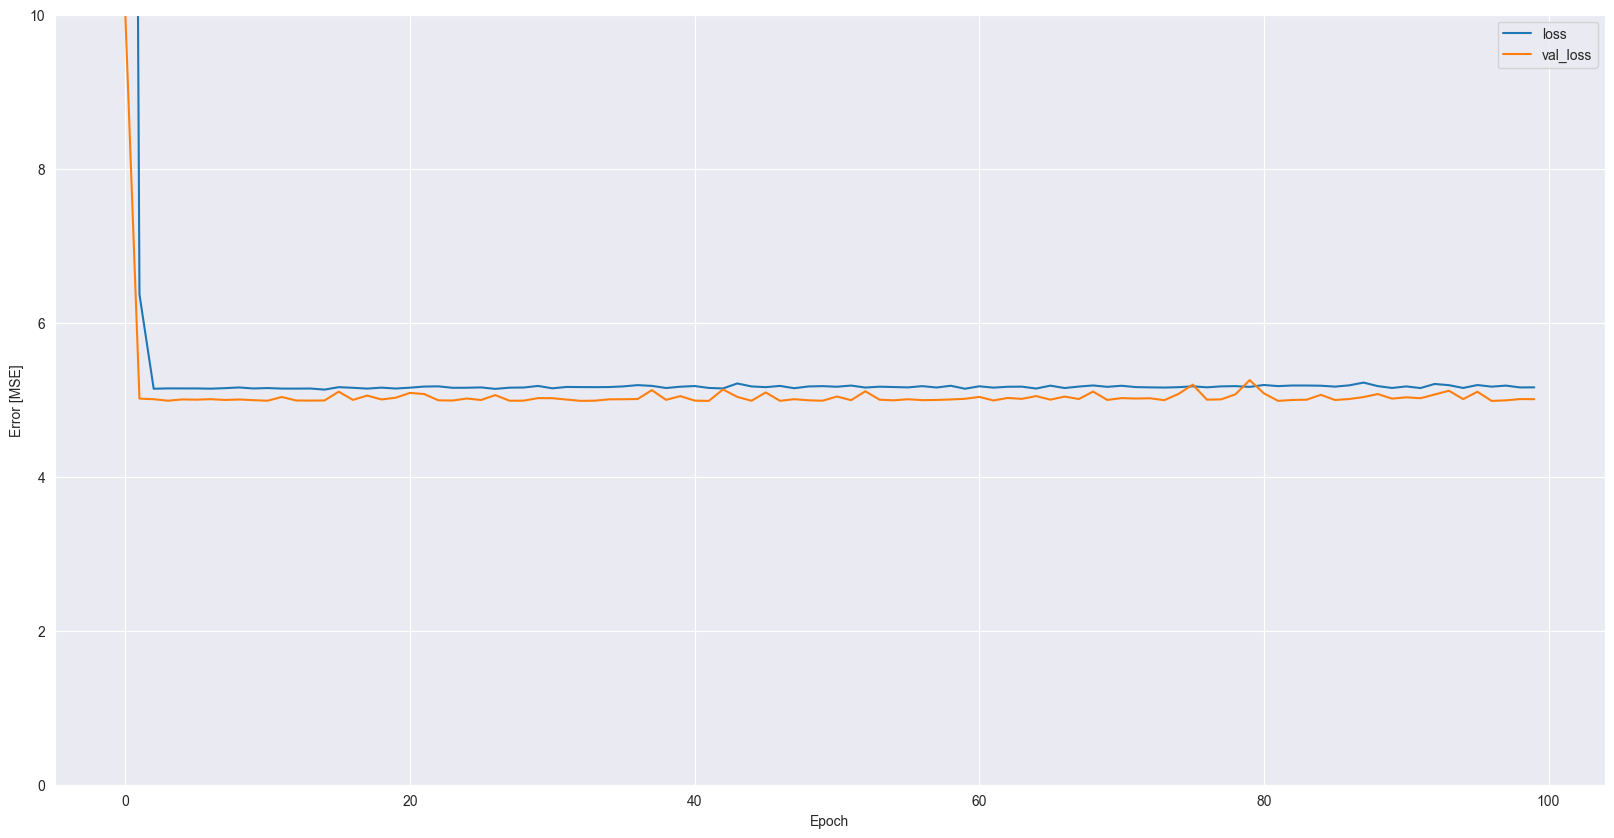

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.legend()
    plt.grid(True)

plot_loss(history)


### Predict After Training

To see if training improved the model.


In [15]:
shell_weight_target = np.array(crabs['Age'])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
[9 6 6 ... 5 6 8]
[9.61299   7.0220823 7.6235867 ... 6.5615635 7.7299356 6.950858 ]


#### Scores After Training

Reminder of our metrics:

- **Mean Squared Error**: The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**: The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**: The best possible score is 1.0, lower values are worse.
- **R2 Score**: The best possible score is 1.0, lower values are worse.
- **Max Error**: The max error is the worst possible score.
 

In [16]:
scores = score_model(shell_weight_preds, shell_weight_target)

scores_df = pd.DataFrame(scores, index=['train'])
scores_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
train,5.144802,1.659214,-0.439495,-0.450103,10.491475


#### Post-Training Observations

The scores are better after training, but not by much. The model is still underfitting.

Shell weight alone must not be a good predictor of crab age.


#### Compare Pre- and Post-Training Predictions

In [17]:
combined_scores_df = pd.concat([scores_df, naive_scores_df], axis=0)
combined_scores_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
train,5.144802,1.659214,-0.439495,-0.450103,10.491475
naive,100.092461,9.742474,-1.246667,-42.439912,19.838175


#### Bar Charts of Scores

<Axes: title={'center': 'Naive vs Trained Model Scores'}>

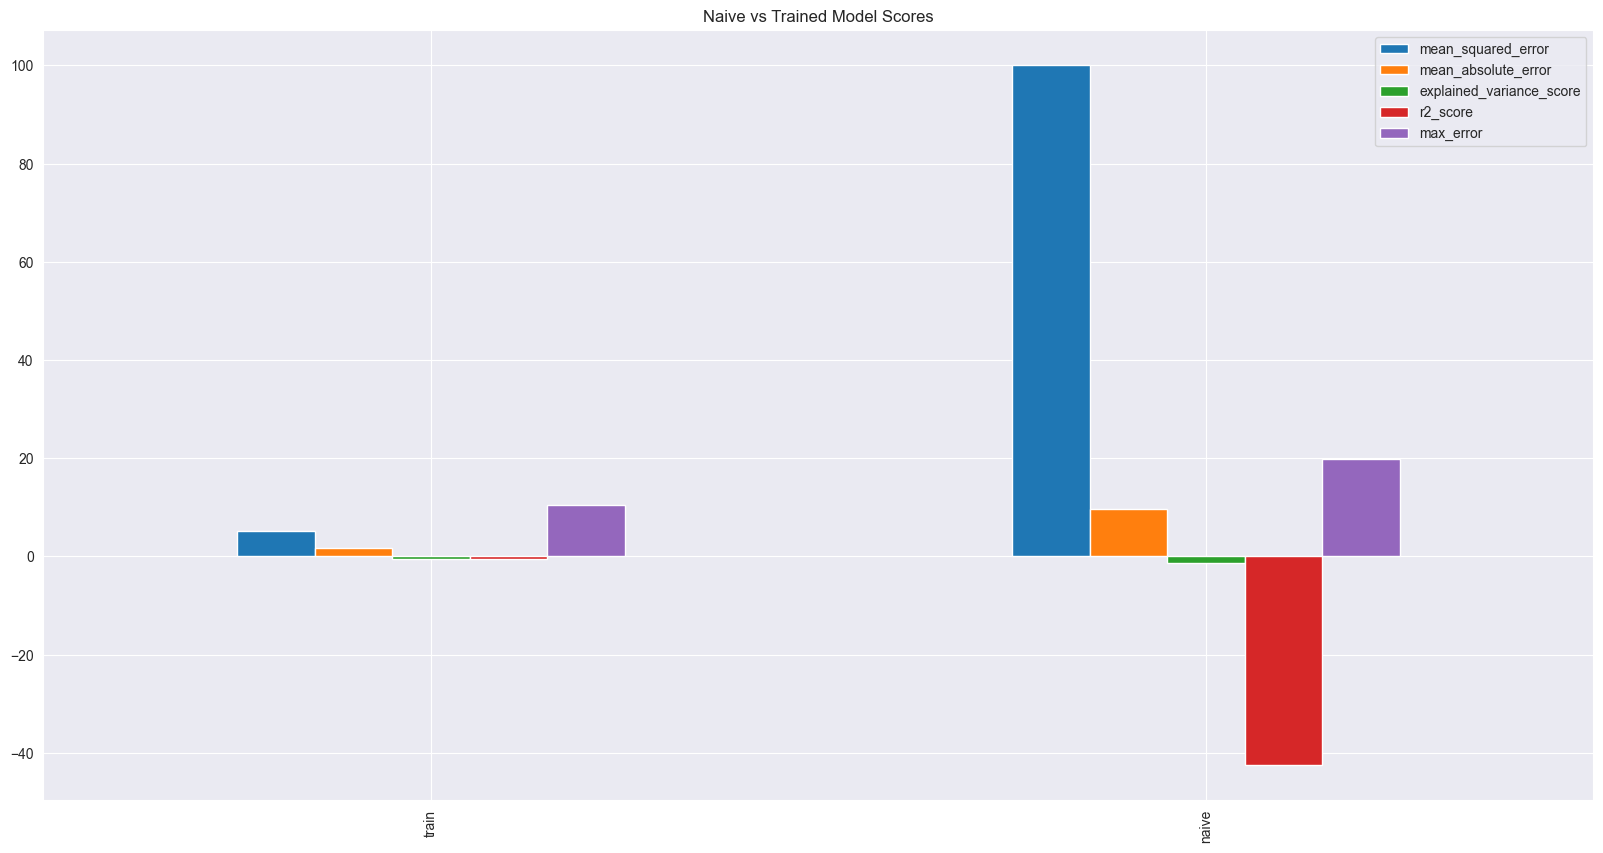

In [18]:
combined_scores_df.plot(kind='bar', title='Naive vs Trained Model Scores', figsize=(20, 10))


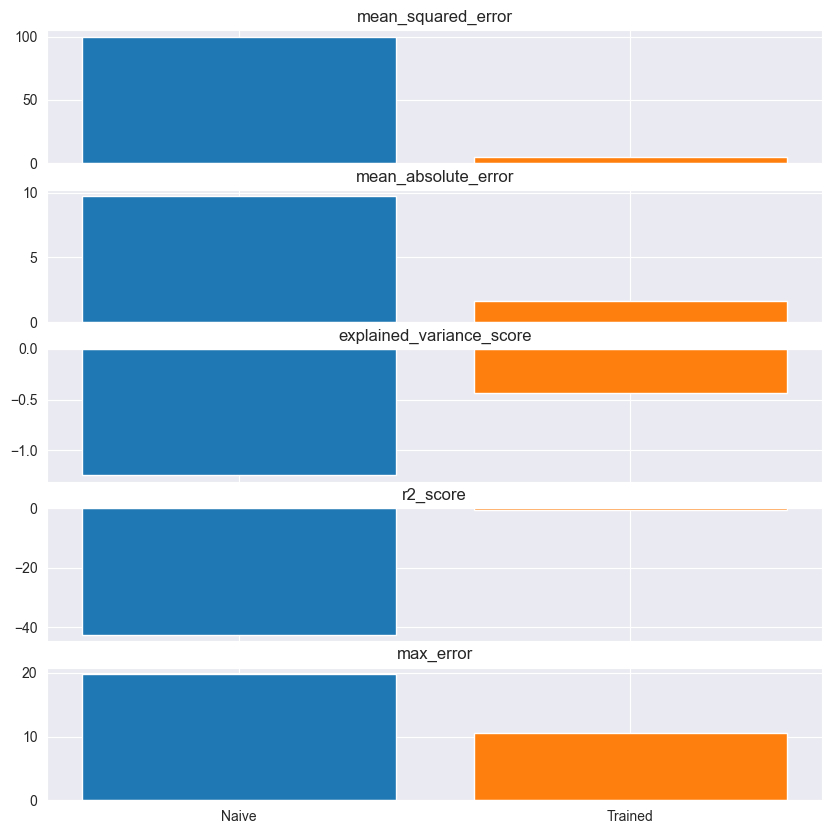

In [19]:
# Utility functions imported from mlutils.py
score_comparator(naive_scores_df, scores_df, train_label='Naive', test_label='Trained')


### Adding Complexity

In order to overfit, we're going to need to give the model more features from the dataset.

Shell Weight alone is not going to cut it.


### Don't Save this Data

We don't want our over-trained model to leak into the [next step](../1-models/models.ipynb).


### Onwards to Model Selection

See the [next section](../1-models/models.ipynb) for model selection.
